In [1]:
import os
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from glob import glob
from tslearn import barycenters
from scipy.stats import wasserstein_distance

# Add rpy2
%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(cowplot)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [3]:
# load pyspi SPI info
pyspi_SPI_info = pd.read_csv("../feature_extraction/pyspi_SPI_info.csv")

# Define path for derivatives directory
deriv_dir = "/Users/abry4213/data/Cogitate_MEG/derivatives"

# Initialize list for pyspi results
all_pyspi_res_averaged_epochs_list = []

# Load pyspi results -- update to where you have stored your pyspi results
pyspi_res_path_averaged = f"{deriv_dir}/time_series_features/averaged_epochs"

# Load in pyspi results
# for pyspi_res_file in os.listdir(pyspi_res_path_averaged):
for pyspi_res_file in glob(f"{pyspi_res_path_averaged}/*pyspi*.csv"):
    pyspi_res_averaged = pd.read_csv(pyspi_res_file)
    all_pyspi_res_averaged_epochs_list.append(pyspi_res_averaged)
    
# Concatenate pyspi results
all_barycenter_res_averaged_epochs = pd.concat(all_pyspi_res_averaged_epochs_list).query("SPI.str.contains('bary')")

# Specifically filter to bary_euclidean
bary_sq_euclidean_res_averaged_epochs = all_barycenter_res_averaged_epochs.query("SPI.str.contains('bary-sq_euclidean')")

# Case study: Barycenter visualization for two subjects

### Visualizing the squared barycenter with Euclidean distance [mean] SPI

In [81]:
# Extract the time series for this subject
sub_CB038_time_series = pd.read_csv(f"{deriv_dir}/MEG_time_series/sub-CB038_ses-1_meg_1000ms_all_time_series.csv")
sub_CB038_time_series_of_interest = sub_CB038_time_series.query("relevance_type == 'Irrelevant' & stimulus_type in ['face', 'False'] & times >= 0.0 & times < 1")

# Compute the CS <--> IPS barycenter with Euclidean distance

# False stimuli
sub_CB038_CS_false = sub_CB038_time_series_of_interest.query("stimulus_type == 'False'").Category_Selective.values
sub_CB038_IPS_false = sub_CB038_time_series_of_interest.query("stimulus_type == 'False'").IPS.values
# z-score the time series
sub_CB038_CS_false = (sub_CB038_CS_false - sub_CB038_CS_false.mean()) / sub_CB038_CS_false.std()
sub_CB038_IPS_false = (sub_CB038_IPS_false - sub_CB038_IPS_false.mean()) / sub_CB038_IPS_false.std()
sub_CB038_false_barycenter = barycenters.euclidean_barycenter([sub_CB038_CS_false, sub_CB038_IPS_false])

# Face stimuli
sub_CB038_CS_face = sub_CB038_time_series_of_interest.query("stimulus_type == 'face'").Category_Selective.values
sub_CB038_IPS_face = sub_CB038_time_series_of_interest.query("stimulus_type == 'face'").IPS.values
# z-score the time series
sub_CB038_CS_face = (sub_CB038_CS_face - sub_CB038_CS_face.mean()) / sub_CB038_CS_face.std()
sub_CB038_IPS_face = (sub_CB038_IPS_face - sub_CB038_IPS_face.mean()) / sub_CB038_IPS_face.std()
sub_CB038_face_barycenter = barycenters.euclidean_barycenter([sub_CB038_CS_face, sub_CB038_IPS_face])

# Flatten the barycenter arrays from (1000,1) to (1000,)
sub_CB038_false_barycenter = sub_CB038_false_barycenter.flatten()
sub_CB038_face_barycenter = sub_CB038_face_barycenter.flatten()

# Square the barycenter arrays
sub_CB038_false_barycenter_sq = np.square(sub_CB038_false_barycenter)
sub_CB038_face_barycenter_sq = np.square(sub_CB038_face_barycenter)

# Print the mean squared barycenter for face vs false
print("Mean squared barycenter for face stimuli: ", np.mean(sub_CB038_face_barycenter_sq))
print("Mean squared barycenter for false stimuli: ", np.mean(sub_CB038_false_barycenter_sq))

Mean squared barycenter for face stimuli:  0.2970573114719432
Mean squared barycenter for false stimuli:  0.5944635036343306


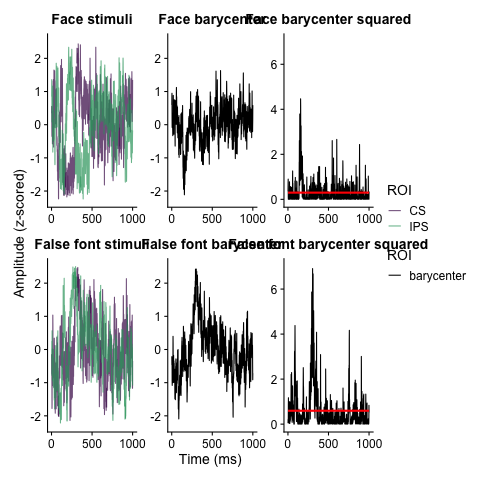

In [82]:
%%R -i sub_CB038_false_barycenter,sub_CB038_face_barycenter,sub_CB038_false_barycenter_sq,sub_CB038_face_barycenter_sq,sub_CB038_CS_face,sub_CB038_IPS_face,sub_CB038_CS_false,sub_CB038_IPS_false

# Plot time series vs barycenter for face
face_barycenter_ts_p <- data.frame(times=1:length(sub_CB038_face_barycenter_sq), IPS = sub_CB038_IPS_face,
           CS = sub_CB038_CS_face) %>%
    pivot_longer(cols=c("IPS", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line(alpha=0.7) +
    ggtitle("Face stimuli") 

# Plot barycenter only for face
face_barycenter_p <- data.frame(times=1:length(sub_CB038_face_barycenter), 
                                value = sub_CB038_face_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line() +
    ggtitle("Face barycenter")

# Plot barycenter squared only for face
face_barycenter_sq_p <- data.frame(times=1:length(sub_CB038_face_barycenter_sq), 
                                value = sub_CB038_face_barycenter_sq,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    geom_line() +
    stat_smooth(method="lm", formula=y~1, se=FALSE, color="red") +
    scale_y_continuous(limits=c(0,7)) +
    ggtitle("Face barycenter squared")

# Plot time series vs barycenter for false
false_barycenter_ts_p <- data.frame(times=1:length(sub_CB038_false_barycenter_sq), 
IPS = sub_CB038_IPS_false,
           CS = sub_CB038_CS_false) %>%
    pivot_longer(cols=c("IPS", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line(alpha=0.7) +
    ggtitle("False font stimuli")

# Plot barycenter only for false
false_barycenter_p <- data.frame(times=1:length(sub_CB038_false_barycenter),
                                value = sub_CB038_false_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black",
                                "IPS" = "#2ea16b",
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line() +
    ggtitle("False font barycenter")

# Plot barycenter squared only for false
false_barycenter_sq_p <- data.frame(times=1:length(sub_CB038_false_barycenter_sq), 
                                value = sub_CB038_false_barycenter_sq,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    geom_line() +
    stat_smooth(method="lm", formula=y~1, se=FALSE, color="red")+
    scale_y_continuous(limits=c(0,7)) +
    ggtitle("False font barycenter squared")

# Time series plus barycenter
wrap_plots(list(face_barycenter_ts_p, face_barycenter_p, face_barycenter_sq_p,
       false_barycenter_ts_p, false_barycenter_p, false_barycenter_sq_p), ncol=3) +
       plot_layout(axis_titles = "collect", guides = "collect") &
       theme(plot.title = element_text(hjust = 0.5, size=14)) &
       xlab("Time (ms)") &
       ylab("Amplitude (z-scored)") &
       scale_x_continuous(breaks=c(0, 500, 1000))

# ggsave("../plots/inter_subject_classification/Time_series_vs_barycenter_for_face_and_false_font_CB038.svg", width=7, height=4, units='in', dpi=300)

### Visualize an example for max of squared barycenter with soft-DTW geometry between the CS and IPS regions

In [83]:
# Extract the time series for this subject
sub_CB073_time_series = pd.read_csv(f"{deriv_dir}/MEG_time_series/sub-CB073_ses-1_meg_1000ms_all_time_series.csv")
sub_CB073_time_series_of_interest = sub_CB073_time_series.query("relevance_type == 'Irrelevant' & stimulus_type in ['face', 'object'] & times >= 0.0 & times < 1")

# Compute the CS <--> IPS barycenter with expectation maximisation (dtw)

# object stimuli stimuli
sub_CB073_CS_object = sub_CB073_time_series_of_interest.query("stimulus_type == 'object'").Category_Selective.values
sub_CB073_PFC_object = sub_CB073_time_series_of_interest.query("stimulus_type == 'object'").Prefrontal_Cortex.values
# z-score the time series
sub_CB073_CS_object = (sub_CB073_CS_object - sub_CB073_CS_object.mean()) / sub_CB073_CS_object.std()
sub_CB073_PFC_object = (sub_CB073_PFC_object - sub_CB073_PFC_object.mean()) / sub_CB073_PFC_object.std()
sub_CB073_object_barycenter = barycenters.dtw_barycenter_averaging([sub_CB073_CS_object, sub_CB073_PFC_object])

# Face stimuli
sub_CB073_CS_face = sub_CB073_time_series_of_interest.query("stimulus_type == 'face'").Category_Selective.values
sub_CB073_PFC_face = sub_CB073_time_series_of_interest.query("stimulus_type == 'face'").Prefrontal_Cortex.values
# z-score the time series
sub_CB073_CS_face = (sub_CB073_CS_face - sub_CB073_CS_face.mean()) / sub_CB073_CS_face.std()
sub_CB073_PFC_face = (sub_CB073_PFC_face - sub_CB073_PFC_face.mean()) / sub_CB073_PFC_face.std()
sub_CB073_face_barycenter = barycenters.dtw_barycenter_averaging([sub_CB073_CS_face, sub_CB073_PFC_face])

# Flatten the barycenter arrays from (1000,1) to (1000,)
sub_CB073_object_barycenter = sub_CB073_object_barycenter.flatten()
sub_CB073_face_barycenter = sub_CB073_face_barycenter.flatten()

# Square the barycenter arrays
sub_CB073_object_barycenter_sq = np.square(sub_CB073_object_barycenter)
sub_CB073_face_barycenter_sq = np.square(sub_CB073_face_barycenter)

# Print the mean squared barycenter for face vs object
print("Max squared barycenter for face stimuli: ", np.max(sub_CB073_face_barycenter_sq))
print("Max squared barycenter for object stimuli: ", np.max(sub_CB073_object_barycenter_sq))

Max squared barycenter for face stimuli:  11.171084959146794
Max squared barycenter for object stimuli:  7.485024083063338


In [84]:
# At what index is the max of sub_CB073_face_barycenter_sq?
print("Index of max squared barycenter for face stimuli: ", np.argmax(sub_CB073_face_barycenter_sq))

Index of max squared barycenter for face stimuli:  150


In [85]:
%%R -i sub_CB073_object_barycenter,sub_CB073_face_barycenter,sub_CB073_object_barycenter_sq,sub_CB073_face_barycenter_sq,sub_CB073_CS_face,sub_CB073_PFC_face,sub_CB073_CS_object,sub_CB073_PFC_object

linewidth=0.2
PFC_color="#cdb902"
CS_color="#410151"
ts_range=c(-4, 4)
squared_range=c(0, 12)

# Plot time series vs barycenter for face
face_barycenter_ts_p <- data.frame(times=1:length(sub_CB073_face_barycenter_sq), PFC = sub_CB073_PFC_face,
           CS = sub_CB073_CS_face) %>%
    pivot_longer(cols=c("PFC", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(alpha=0.7, linewidth=linewidth) +
    ggtitle("Face stimuli") 

# Plot barycenter only for face
face_barycenter_p <- data.frame(times=1:length(sub_CB073_face_barycenter), 
                                value = sub_CB073_face_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(linewidth=0.5) +
    ggtitle("Face barycenter")

# Plot barycenter squared only for face
face_barycenter_sq_p <- data.frame(times=1:length(sub_CB073_face_barycenter_sq), 
                                value = sub_CB073_face_barycenter_sq,
                                ROI = "barycenter") %>%
    mutate(max_value = max(value)) %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    geom_line(linewidth=linewidth) +
    # Add a horizontal line corresponding to the maximum value of the barycenter squared
    geom_hline(aes(yintercept=max_value), color="red") +
    scale_y_continuous(limits=squared_range) +
    ggtitle("Face barycenter squared")

# Plot time series vs barycenter for object
object_barycenter_ts_p <- data.frame(times=1:length(sub_CB073_object_barycenter_sq), 
PFC = sub_CB073_PFC_object,
           CS = sub_CB073_CS_object) %>%
    pivot_longer(cols=c("PFC", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(alpha=0.7, linewidth=linewidth) +
    ggtitle("Object stimuli")

# Plot barycenter only for object
object_barycenter_p <- data.frame(times=1:length(sub_CB073_object_barycenter),
                                value = sub_CB073_object_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(linewidth=linewidth) +
    ggtitle("Object barycenter")

# Plot barycenter squared only for object
object_barycenter_sq_p <- data.frame(times=1:length(sub_CB073_object_barycenter_sq), 
                                value = sub_CB073_object_barycenter_sq,
                                ROI = "barycenter") %>%
    mutate(max_value = max(value)) %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    geom_line(linewidth=linewidth) +
    # Add a horizontal line corresponding to the maximum value of the barycenter squared
    geom_hline(aes(yintercept=max_value), color="red") +
    scale_y_continuous(limits=squared_range) +
    ggtitle("Object barycenter squared")

# Time series plus barycenter
wrap_plots(list(face_barycenter_ts_p, face_barycenter_p, face_barycenter_sq_p,
       object_barycenter_ts_p, object_barycenter_p, object_barycenter_sq_p), ncol=3) +
       plot_layout(axis_titles = "collect", guides = "collect") &
       theme(plot.title = element_text(hjust = 0.5, size=14)) &
       xlab("Time (ms)") &
       ylab("Amplitude (z-scored)") &
       scale_x_continuous(breaks=c(0, 500, 1000))

ggsave("../plots/inter_subject_classification/Time_series_vs_barycenter_for_face_and_object_CB073.svg", width=7, height=4, units='in', dpi=300)

# Zooming out to examine general trends in barycenter

### Across all stimulus types, how do the barycenter mean/max compare for the different geometries? (Euclidean, DTW, SGD-DTW, soft-DTW)

In [86]:
%%R -i all_barycenter_res_averaged_epochs

for (this_stim in unique(all_barycenter_res_averaged_epochs$stimulus_type)) {
       all_barycenter_res_averaged_epochs %>% 
              filter(stimulus_type==this_stim & relevance_type == "Relevant non-target") %>%
              mutate(SPI_stat = ifelse(str_detect(SPI, "_mean"), "Mean", "Max")) %>% 
              mutate(SPI_base = gsub("_mean|_max", "", SPI)) %>% 
              mutate(meta_ROI_pair = glue("{meta_ROI_from}__{meta_ROI_to}")) %>%
              filter(meta_ROI_pair %in% c("Category_Selective__V1_V2", "Category_Selective__Prefrontal_Cortex")) %>%
              mutate(meta_ROI_pair = ifelse(meta_ROI_pair == "Category_Selective__V1_V2", "CS <-> VIS", "CS <-> PFC")) %>%
              mutate(SPI_base = factor(SPI_base, levels=c("bary_euclidean", "bary_dtw", 
                                                        "bary_softdtw", "bary_sgddtw", 
                                                        "bary-sq_euclidean", "bary-sq_dtw", 
                                                        "bary-sq_softdtw","bary-sq_sgddtw"))) %>%
              mutate(SPI__stimulus = glue("{SPI_stat}__{stimulus_presentation}")) %>%
              mutate(SPI__stimulus = factor(SPI__stimulus, levels=c("Mean__on", "Max__on", "Max__off", "Mean__off"))) %>%
              ggplot(data=., mapping=aes(x=SPI__stimulus, y=value, group=subject_ID, color=meta_ROI_pair)) +
              geom_line(alpha=0.4, linewidth=0.3) +
              scale_color_manual(values=c("CS <-> VIS"="#e96893", "CS <-> PFC"="#5b8c00")) +
              facet_grid(SPI_base ~ meta_ROI_pair, scales="free") +
              ggtitle(glue("Stimulus: {this_stim}")) +
              ylab("Barycenter SPI value") +
              xlab("SPI and stimulus presentation") +
              labs(color="") +
              theme(legend.position = "bottom",
                     strip.background = element_blank(),
                     axis.text.x = element_text(angle=30, hjust=1),
                     strip.text.x = element_text(face='bold'),
                     strip.text.y = element_text(angle=0, face='bold')) 
       ggsave(glue("../plots/modeling/Barycenters_mean_max_{this_stim}.png"), width=7, height=10, units='in', dpi=300)
}



/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


### How does the Euclidean barycenter mean/max compare at onset and offset for different region pairs?

In [87]:
%%R -i all_barycenter_res_averaged_epochs

for (geom in c("euclidean", "dtw")) {
    for (bary_type in c("original", "squared")) {
        bary_type_label = ifelse(bary_type=="squared", "-sq", "")
        for (this_rel in c("Relevant non-target", "Irrelevant")) {
            relevance_label = ifelse(this_rel=="Relevant non-target", "Relevant", "Irrelevant")
            print(glue("Now plotting {geom} barycenter{bary_type_label}, {relevance_label}"))
            
            all_barycenter_res_averaged_epochs %>% 
                filter(str_detect(SPI, glue("bary{bary_type_label}_{geom}")),
                    relevance_type == this_rel,
                    stimulus_type %in% c('face', 'object')) %>%
                mutate(SPI = ifelse(str_detect(SPI, "_mean"), "Mean", "Max")) %>% 
                mutate(meta_ROI_pair = glue("{meta_ROI_from}__{meta_ROI_to}")) %>%
                filter(meta_ROI_pair %in% c("Category_Selective__V1_V2", "Category_Selective__Prefrontal_Cortex")) %>%
                mutate(meta_ROI_pair = ifelse(meta_ROI_pair == "Category_Selective__V1_V2", "CS <-> VIS", "CS <-> PFC")) %>%
                mutate(SPI__stimulus = glue("{SPI}__{stimulus_presentation}")) %>%
                mutate(SPI__stimulus = factor(SPI__stimulus, levels=c("Mean__on", "Max__on", "Max__off", "Mean__off")),
                    stimulus_type = factor(stimulus_type, levels=c("face", "object"))) %>%
                ggplot(data=., mapping=aes(x=SPI__stimulus, y=value, group=subject_ID, color=meta_ROI_pair)) +
                geom_line(alpha=0.4, linewidth=0.3) +
                scale_color_manual(values=c("CS <-> VIS"="#e96893", "CS <-> PFC"="#5b8c00")) +
                facet_grid(stimulus_type ~ meta_ROI_pair, scales="fixed") +
                scale_x_discrete(expand=c(0.05, 0.05)) +
                ylab("Barycenter SPI value") +
                xlab("SPI and stimulus presentation") +
                ggtitle(glue("{geom} barycenter{bary_type_label}")) +
                labs(color="") +
                theme(legend.position = "bottom",
                        strip.background = element_blank(),
                        plot.title = element_text(hjust = 0.5, size=14),
                        axis.text.x = element_text(angle=30, hjust=1),
                        strip.text.x = element_text(face='bold'),
                        strip.text.y = element_text(angle=0, face='bold')) 
            ggsave(glue("../plots/modeling/Barycenters{bary_type_label}_{geom}_{relevance_label}_mean_max_across_stimuli.svg"), width=6, height=3.5, units='in', dpi=300)
        }
    }
}

Now plotting euclidean barycenter, Relevant
Now plotting euclidean barycenter, Irrelevant
Now plotting euclidean barycenter-sq, Relevant
Now plotting euclidean barycenter-sq, Irrelevant
Now plotting dtw barycenter, Relevant
Now plotting dtw barycenter, Irrelevant
Now plotting dtw barycenter-sq, Relevant
Now plotting dtw barycenter-sq, Irrelevant


### What about the timing of the barycenter max between each ROI--ROI pair?

In [4]:
# Initialize list for pyspi results
all_time_resolved_barycenter_res_list = []

# Load in time-resolved barycenter results
for barycenter_time_res_file in glob(f"{pyspi_res_path_averaged}/*barycenter*.csv"):
    barycenter_time_resolved_res = pd.read_csv(barycenter_time_res_file)
    all_time_resolved_barycenter_res_list.append(barycenter_time_resolved_res)

# Concatenate pyspi results
all_time_resolved_barycenter_res = pd.concat(all_time_resolved_barycenter_res_list)
all_time_resolved_barycenter_res.head()

# Separate out into raw and absolute value barycenter by filtering out where 'Region' contains the string 'abs'
all_raw_time_resolved_barycenter_res = all_time_resolved_barycenter_res.query("Region.str.contains('abs') == False")
all_abs_time_resolved_barycenter_res = all_time_resolved_barycenter_res.query("Region.str.contains('abs') == True").assign(Region=lambda x: x.Region.str.replace("_abs", ""))

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


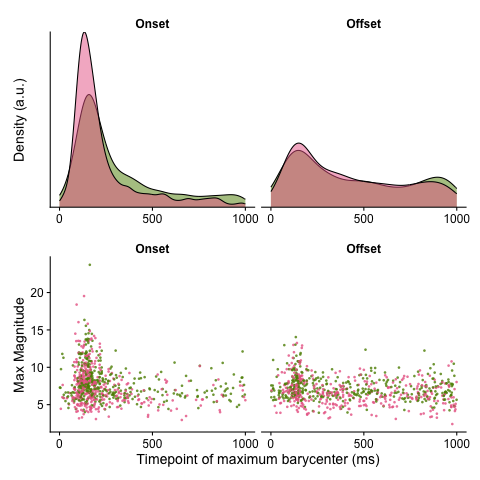

In [12]:
%%R -i all_raw_time_resolved_barycenter_res

bary_max_density_plot <- all_raw_time_resolved_barycenter_res %>% 
    filter(Barycenter_Method == "dtw", Barycenter_Type == "Squared",
           Relevance %in% c("Relevant non-target", "Irrelevant"),
           Presentation %in% c("Onset", "Offset")) %>%
    mutate(Region_Pair = ifelse(Region=="CS_PFC", "CS <-> PFC", "CS <-> VIS"),
           Presentation = factor(Presentation, levels=c("Onset", "Offset"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, fill=Region_Pair)) +
    scale_fill_manual(values=c("CS <-> VIS" = "#e96893", "CS <-> PFC" = "#5b8c00"))  +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(alpha=0.5) +
    facet_grid(. ~ Presentation, scales="free") +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- all_raw_time_resolved_barycenter_res %>% 
    filter(Barycenter_Method == "dtw", Barycenter_Type == "Squared",
           Relevance %in% c("Relevant non-target", "Irrelevant"),
           Stimulus %in% c("face", "False"),
           Presentation %in% c("Onset", "Offset")) %>%
    mutate(Region_Pair = ifelse(Region=="CS_PFC", "CS <-> PFC", "CS <-> VIS"),
           Presentation = factor(Presentation, levels=c("Onset", "Offset"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, y=Max, color=Region_Pair)) +
    geom_point(stroke=0, alpha=0.8, size=1.25) +
    facet_grid(. ~ Presentation, scales="free")  +
    scale_color_manual(values=c("CS <-> VIS" = "#e96893", "CS <-> PFC" = "#5b8c00"))  +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
       plot_layout(axis_titles = "collect", guides = "collect") &
       scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))

# ggsave(glue("../plots/modeling/Barycenters_Sq_DTW_max_timing_across_stimuli.svg"), width=5.5, height=4, units='in', dpi=300)

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


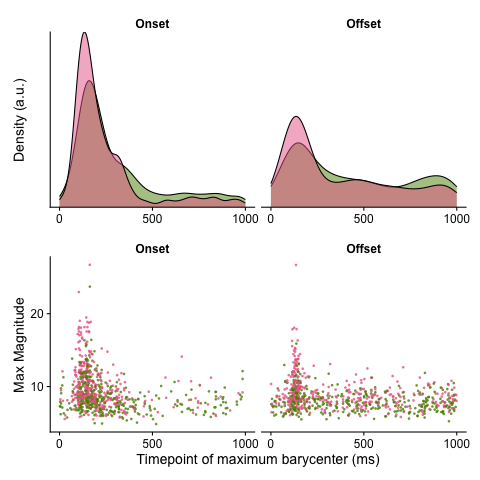

In [15]:
%%R -i all_abs_time_resolved_barycenter_res

bary_max_density_plot <- all_abs_time_resolved_barycenter_res %>% 
    filter(Barycenter_Method == "dtw", Barycenter_Type == "Squared",
           Relevance %in% c("Relevant non-target", "Irrelevant"),
           Presentation %in% c("Onset", "Offset")) %>%
    mutate(Region_Pair = ifelse(Region=="CS_PFC", "CS <-> PFC", "CS <-> VIS"),
           Presentation = factor(Presentation, levels=c("Onset", "Offset"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, fill=Region_Pair)) +
    scale_fill_manual(values=c("CS <-> VIS" = "#e96893", "CS <-> PFC" = "#5b8c00"))  +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(alpha=0.5) +
    facet_grid(. ~ Presentation, scales="free") +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- all_abs_time_resolved_barycenter_res %>% 
    filter(Barycenter_Method == "dtw", Barycenter_Type == "Squared",
           Relevance %in% c("Relevant non-target", "Irrelevant"),
           Stimulus %in% c("face", "False"),
           Presentation %in% c("Onset", "Offset")) %>%
    mutate(Region_Pair = ifelse(Region=="CS_PFC", "CS <-> PFC", "CS <-> VIS"),
           Presentation = factor(Presentation, levels=c("Onset", "Offset"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, y=Max, color=Region_Pair)) +
    geom_point(stroke=0, alpha=0.8, size=1.25) +
    facet_grid(. ~ Presentation, scales="free")  +
    scale_color_manual(values=c("CS <-> VIS" = "#e96893", "CS <-> PFC" = "#5b8c00"))  +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
       plot_layout(axis_titles = "collect", guides = "collect") &
       scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))

# ggsave(glue("../plots/modeling/Barycenters_Sq_DTW_max_timing_across_stimuli_abs_value.svg"), width=5.5, height=4, units='in', dpi=300)

## Compare empirical results with model-derived simulated time series

In [5]:
# Read in model data
N_sims = 1000
model_data_for_comparison = pd.read_csv(f'../modeling/All_simulated_Euclidean_barycenter_squared_max_results_{N_sims}_sims.csv')

# Separate out into raw and abs
model_data_for_comparison_raw = model_data_for_comparison[model_data_for_comparison['Data_Type'] == 'Raw'].assign(Data_Type = "Model")
model_data_for_comparison_abs = model_data_for_comparison[model_data_for_comparison['Data_Type'] == 'Abs'].assign(Data_Type = "Model")

# Wrangle empirical data
empirical_raw_data_for_comparison = (all_raw_time_resolved_barycenter_res
    .query("Presentation in ['Onset', 'Offset'] & Barycenter_Type == 'Squared' & Barycenter_Method == 'euclidean' & Relevance == 'Relevant non-target' & Region in ['CS_PFC', 'CS_VIS']")
    .rename(columns={"Max": "Max_Value", "Presentation": "Stim"})
    .assign(Stim = lambda x: x.Stim.str.replace("set", ""),
            Model = lambda x: np.where(x.Region == "CS_PFC", "GNWT", "IIT")
            )
    [['Max_Time', 'Model', 'Stim', 'Max_Value']]
    .assign(Data_Type = "Empirical")
)
empirical_abs_data_for_comparison = (all_abs_time_resolved_barycenter_res
    .query("Presentation in ['Onset', 'Offset'] & Barycenter_Type == 'Squared' & Barycenter_Method == 'euclidean' & Relevance == 'Relevant non-target' & Region in ['CS_PFC', 'CS_VIS']")
    .rename(columns={"Max": "Max_Value", "Presentation": "Stim"})
    .assign(Stim = lambda x: x.Stim.str.replace("set", ""),
            Model = lambda x: np.where(x.Region == "CS_PFC", "GNWT", "IIT")
            )
    [['Max_Time', 'Model', 'Stim', 'Max_Value']]
    .assign(Data_Type = "Empirical")
)

# Concatenate model and empirical data
all_raw_data_for_comparison = pd.concat([model_data_for_comparison_raw, empirical_raw_data_for_comparison])
all_abs_data_for_comparison = pd.concat([model_data_for_comparison_abs, empirical_abs_data_for_comparison])

### How does the timing and magnitude of the Euclidean squared barycenter compare for simulated vs empirical time series?

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


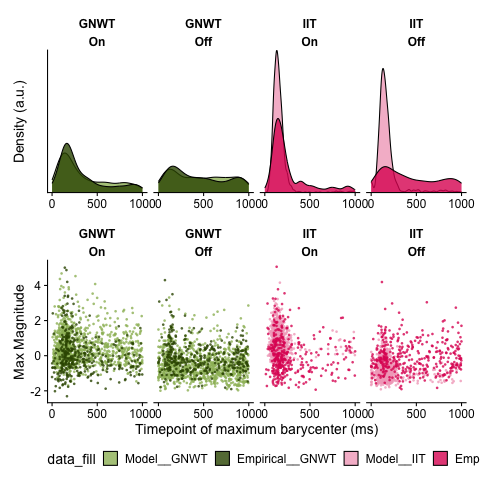

In [31]:
%%R -i all_raw_data_for_comparison

bary_max_density_plot <- all_raw_data_for_comparison %>%
    filter(Data_Type=="Empirical" | Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    mutate(data_fill = factor(data_fill, levels=rev(c("Empirical__IIT", "Model__IIT", 
                                                      "Empirical__GNWT", "Model__GNWT")))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, fill=data_fill)) +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(alpha=0.8) +
#     facet_grid(Model ~ Stim, scales="free") +
    facet_wrap(Model ~ Stim, scales="free_x", nrow=1) +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    scale_fill_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66"))  +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- all_raw_data_for_comparison %>% 
    filter(Data_Type=="Empirical" | Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    mutate(data_fill = factor(data_fill, levels=rev(c("Empirical__IIT", "Model__IIT", 
                                                      "Empirical__GNWT", "Model__GNWT")))) %>%
    group_by(data_fill) %>%
    mutate(Max_Value_Z = (Max_Value - mean(Max_Value)) / sd(Max_Value)) %>%
    ggplot(data=., mapping=aes(x=Max_Time, y=Max_Value_Z, color=data_fill)) +
    geom_point(stroke=0, alpha=0.8, size=1.25) +
    facet_wrap(Model ~ Stim, scales="free_x", nrow=1) +
    scale_color_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66"))  +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
      plot_layout(axis_titles = "collect", guides = "collect") &
      theme(legend.position="bottom") &
      scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))

# ggsave("../plots/modeling/Model_vs_empirical_barycenter_max_timing.svg", width=8, height=5, units='in', dpi=300)

In [33]:
%%R -i all_abs_data_for_comparison

bary_max_density_plot <- all_abs_data_for_comparison %>%
    filter(Data_Type=="Empirical" | Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    mutate(data_fill = factor(data_fill, levels=rev(c("Empirical__IIT", "Model__IIT", 
                                                      "Empirical__GNWT", "Model__GNWT")))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, fill=data_fill)) +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(alpha=0.8) +
#     facet_grid(Model ~ Stim, scales="free") +
    facet_wrap(Model ~ Stim, scales="free_x", nrow=1) +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    scale_fill_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66"))  +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- all_abs_data_for_comparison %>% 
    filter(Data_Type=="Empirical" | Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    mutate(data_fill = factor(data_fill, levels=rev(c("Empirical__IIT", "Model__IIT", 
                                                      "Empirical__GNWT", "Model__GNWT")))) %>%
    group_by(data_fill) %>%
    mutate(Max_Value_Z = (Max_Value - mean(Max_Value)) / sd(Max_Value)) %>%
    ggplot(data=., mapping=aes(x=Max_Time, y=Max_Value_Z, color=data_fill)) +
    geom_point(stroke=0, alpha=0.8, size=1.25) +
    facet_wrap(Model ~ Stim, scales="free_x", nrow=1) +
    scale_color_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66"))  +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
      plot_layout(axis_titles = "collect", guides = "collect") &
      theme(legend.position="bottom") &
      scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))

# ggsave("../plots/modeling/Model_vs_empirical_barycenter_max_timing_abs_value.svg", width=8, height=5, units='in', dpi=300)

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


In [6]:
def kl_divergence_from_counts(P_counts, Q_counts, units="bits", num_bins=100, epsilon=1e-10):
    """
    Compute the Kullback-Leibler divergence between two discrete distributions
    given their observed counts (P_counts and Q_counts), with automatic binning.

    Args:
    P_counts (array-like): Observed counts for the first distribution.
    Q_counts (array-like): Observed counts for the second distribution.
    num_bins (int): The number of bins to use for both distributions.
    epsilon (float): Small value to avoid division by zero or log of zero.

    Returns:
    float: The KL divergence D(P || Q).
    """
    # The bins should be the same for both P and Q
    
    # Compute shared bin edges based on the range of both distributions
    min_val = min(np.min(P_counts), np.min(Q_counts))
    max_val = max(np.max(P_counts), np.max(Q_counts))
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)

    # Create histograms (bins) for both P and Q using the same bin edges
    P_hist, _ = np.histogram(P_counts, bins=bin_edges, density=True)
    Q_hist, _ = np.histogram(Q_counts, bins=bin_edges, density=True)
    
    # Normalize the histograms so they sum to 1 (convert to probability distributions)
    P_hist = P_hist / P_hist.sum()
    Q_hist = Q_hist / Q_hist.sum()

    # Clip values to avoid log(0) or division by zero
    P_hist = np.clip(P_hist, epsilon, 1)
    Q_hist = np.clip(Q_hist, epsilon, 1)

    # Compute KL divergence in bits or nats
    if units == "bits":
        kl_div = np.sum(P_hist * np.log2(P_hist / Q_hist))
    else:
        kl_div = np.sum(P_hist * np.log(P_hist / Q_hist))

    return kl_div

def compute_KL_divergence_between_model_and_empirical(empirical_data, model_data, num_bins=100, units="bits"):
    """Compute the KL divergence between empirical and model data."
    """

    KL_result_list = []
    # Iterate over stimulus values 
    for stim_type in empirical_data.Stim.unique():
        # Extract empirical data for this stimulus type
        empirical_data_stim = empirical_data.query(f"Stim == '{stim_type}'")
        # Extract model data for this stimulus type
        model_data_stim = model_data.query(f"Stim == '{stim_type}'") 

        # # Compute the KL divergence
        KL_divergence = kl_divergence_from_counts(empirical_data_stim.Max_Time, model_data_stim.Max_Time, num_bins=num_bins, units=units)

        # Put into dataframe
        KL_result_list.append(pd.DataFrame({"Stim": [stim_type], "KL_Divergence": [KL_divergence]}))

    KL_result = pd.concat(KL_result_list)

    # Return the KL divergence
    return KL_result


In [7]:
# Compute the KL divergence between the model and empirical data
all_KL_results_list = []
for model in ["GNWT", "IIT"]:
    for noise_level in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        # Raw data
        this_model_noise_KL_raw = compute_KL_divergence_between_model_and_empirical(all_raw_data_for_comparison.query("Model == @model & Data_Type == 'Empirical'"), 
                                                                                all_raw_data_for_comparison.query("Model == @model & Data_Type == 'Model' & Noise==@noise_level"),
                                                                                num_bins=100, units="bits")
        this_model_noise_KL_raw["Model"] = model
        this_model_noise_KL_raw["Noise"] = noise_level
        this_model_noise_KL_raw["Data_Type"] = "Raw"

        # Append to list
        all_KL_results_list.append(this_model_noise_KL_raw)

        # Absolute value data
        this_model_noise_KL_abs = compute_KL_divergence_between_model_and_empirical(all_abs_data_for_comparison.query("Model == @model & Data_Type == 'Empirical'"), 
                                                                                all_abs_data_for_comparison.query("Model == @model & Data_Type == 'Model' & Noise==@noise_level"),
                                                                                num_bins=100, units="bits")
        
        this_model_noise_KL_abs["Model"] = model
        this_model_noise_KL_abs["Noise"] = noise_level
        this_model_noise_KL_abs["Data_Type"] = "Abs"

        # Append to list
        all_KL_results_list.append(this_model_noise_KL_abs)

# Concatenate the results
all_KL_results = pd.concat(all_KL_results_list)
all_KL_results.query("Noise == 1").sort_values(['Data_Type', 'Model'])

,Stim,KL_Divergence,Model,Noise,Data_Type
0,On,0.427807,GNWT,1.0,Abs
0,Off,0.364281,GNWT,1.0,Abs
0,On,3.259674,IIT,1.0,Abs
0,Off,3.895617,IIT,1.0,Abs
0,On,0.379623,GNWT,1.0,Raw
0,Off,0.339513,GNWT,1.0,Raw
0,On,4.396596,IIT,1.0,Raw
0,Off,7.472942,IIT,1.0,Raw


In [45]:
# Compute Wasserstein distance between model and empirical data
all_WD_results_list = []
for model in ["GNWT", "IIT"]:
    for noise_level in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        for stim_type in ["On", "Off"]:

            # Raw data
            raw_data = all_raw_data_for_comparison.query("Stim == @stim_type & Model == @model & Data_Type == 'Empirical'")
            model_data = all_raw_data_for_comparison.query("Stim == @stim_type & Model == @model & Data_Type == 'Model' & Noise==@noise_level")
            this_model_noise_WD_raw = wasserstein_distance(raw_data.Max_Time, model_data.Max_Time)

            # Absolute value data
            abs_data = all_abs_data_for_comparison.query("Stim == @stim_type & Model == @model & Data_Type == 'Empirical'")
            model_data = all_abs_data_for_comparison.query("Stim == @stim_type & Model == @model & Data_Type == 'Model' & Noise==@noise_level")
            this_model_noise_WD_abs = wasserstein_distance(abs_data.Max_Time, model_data.Max_Time)

            # Put into dataframe
            all_WD_results_list.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "Data_Type": ["Raw"], "WD": [this_model_noise_WD_raw]}))
            all_WD_results_list.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "Data_Type": ["Abs"], "WD": [this_model_noise_WD_abs]}))

# Concatenate the results
all_WD_results = pd.concat(all_WD_results_list)
all_WD_results.query("Noise == 1").sort_values(['Data_Type', 'Model'])

,Model,Stim,Noise,Data_Type,WD
0,GNWT,On,1.0,Abs,66.200957
0,GNWT,Off,1.0,Abs,33.416936
0,IIT,On,1.0,Abs,95.910745
0,IIT,Off,1.0,Abs,177.790957
0,GNWT,On,1.0,Raw,38.400894
0,GNWT,Off,1.0,Raw,29.193830
0,IIT,On,1.0,Raw,110.314298
0,IIT,Off,1.0,Raw,266.152787


### How does the barycenter max timing distribute across noise levels from 0.5 to 1 SD?

In [9]:
%%R -i all_abs_data_for_comparison

plasma_colors <- viridis::inferno(6)[1:5]

all_abs_data_for_comparison %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, group=Noise, color=Noise)) +
    # Set density line alpha to 0.6
    geom_density(aes(color = Noise), alpha = 0.6, fill = NA, key_glyph = draw_key_path) +
    facet_grid(Model ~ Stim, scales='free') +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)")   +
    scale_color_gradientn(colors=plasma_colors) +
    guides(color=guide_legend(title="Noise Level (SD)", override.aes = list(linewidth = 3), nrow=1)) +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

ggsave("../plots/modeling/Noise_model_vs_empirical_max_Euclidean_squared_barycenter.svg", width=5.5, height=4, units='in', dpi=300)

In [13]:
%%R -i all_KL_results 

plasma_colors <- viridis::inferno(6)[1:5]

all_KL_results %>% 
    filter(Data_Type=="Raw") %>%
    ggplot(data=., mapping=aes  (x=Noise, y=KL_Divergence)) +
    geom_line(aes(group=Model), color='gray70') +
    geom_point(aes(color=Noise), size=2.5) +
    scale_color_gradientn(colors=plasma_colors) +
    facet_wrap(Model ~ Stim, scales="free") +
    theme(legend.position="none")
ggsave("../plots/modeling/Noise_model_vs_empirical_DKL.svg", width=4.5, height=4, units='in', dpi=300)

### Robustness analysis: irrelevant rather than relevant non-target setting

In [47]:
# Read in model data
N_sims = 1000
model_data_for_comparison = pd.read_csv(f'../modeling/All_simulated_Euclidean_barycenter_squared_max_results_{N_sims}_sims.csv').assign(Data_Type = "Model")

# Wrangle empirical data
empirical_data_for_comparison_irrel = (all_time_resolved_barycenter_res
    .query("Presentation in ['Onset', 'Offset'] & Barycenter_Type == 'Squared' & Barycenter_Method == 'euclidean' & Relevance == 'Irrelevant' & Region in ['CS_PFC', 'CS_VIS']")
    .rename(columns={"Max": "Max_Value", "Presentation": "Stim"})
    .assign(Stim = lambda x: x.Stim.str.replace("set", ""),
            Model = lambda x: np.where(x.Region == "CS_PFC", "GNWT", "IIT")
            )
    [['Max_Time', 'Model', 'Stim', 'Max_Value']]
    .assign(Data_Type = "Empirical")
)

# Concatenate model and empirical data
all_data_for_comparison_irrel = pd.concat([model_data_for_comparison, empirical_data_for_comparison_irrel])


# Compute the KL divergence between the model and empirical data
all_KL_results_list_irrel = []
for model in ["GNWT", "IIT"]:
    for noise_level in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        this_model_noise_KL = compute_KL_divergence_between_model_and_empirical(all_data_for_comparison_irrel.query("Model == @model & Data_Type == 'Empirical'"), 
                                                                                all_data_for_comparison_irrel.query("Model == @model & Data_Type == 'Model' & Noise==@noise_level"),
                                                                                num_bins=100, units="bits")
        this_model_noise_KL["Model"] = model
        this_model_noise_KL["Noise"] = noise_level

        # Append to list
        all_KL_results_list_irrel.append(this_model_noise_KL)

# Concatenate the results
all_KL_results_irrel = pd.concat(all_KL_results_list_irrel)
all_KL_results_irrel.query("Noise==1")

,Stim,KL_Divergence,Model,Noise
0,On,0.385353,GNWT,1.0
0,Off,0.370436,GNWT,1.0
0,On,4.567148,IIT,1.0
0,Off,3.755053,IIT,1.0


In [48]:
# Wasserstein distances
all_WD_results_list_irrel = []
for model in ["GNWT", "IIT"]:
    for noise_level in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        for stim_type in ["On", "Off"]:
            # Raw data
            raw_data = all_data_for_comparison_irrel.query("Stim == @stim_type & Model == @model & Data_Type == 'Empirical'")
            model_data = all_data_for_comparison_irrel.query("Stim == @stim_type & Model == @model & Data_Type == 'Model' & Noise==@noise_level")
            this_model_noise_WD = wasserstein_distance(raw_data.Max_Time, model_data.Max_Time)

            # Put into dataframe
            all_WD_results_list_irrel.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "WD": [this_model_noise_WD]}))

# Concatenate the results
all_WD_results_irrel = pd.concat(all_WD_results_list_irrel)
all_WD_results_irrel.query("Noise == 1")

,Model,Stim,Noise,WD
0,GNWT,On,1.0,37.546830
0,GNWT,Off,1.0,30.416489
0,IIT,On,1.0,79.289862
0,IIT,Off,1.0,266.241936


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


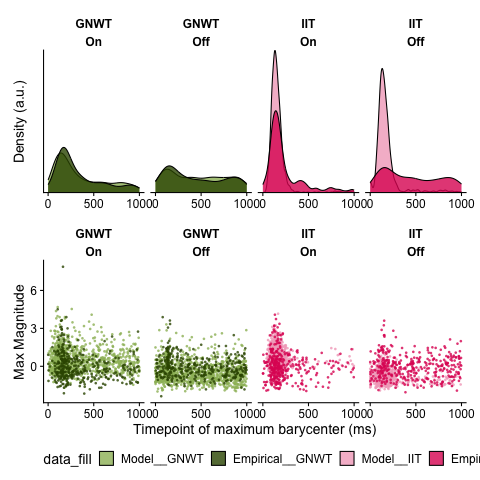

In [38]:
%%R -i all_data_for_comparison_irrel

bary_max_density_plot <- all_data_for_comparison_irrel %>%
    filter(Data_Type=="Empirical" | Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    mutate(data_fill = factor(data_fill, levels=rev(c("Empirical__IIT", "Model__IIT", 
                                                      "Empirical__GNWT", "Model__GNWT")))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, fill=data_fill)) +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(alpha=0.8) +
    facet_wrap(Model ~ Stim, scales="free_x", nrow=1) +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    scale_fill_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66"))  +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- all_data_for_comparison_irrel %>% 
    filter(Data_Type=="Empirical" | Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    mutate(data_fill = factor(data_fill, levels=rev(c("Empirical__IIT", "Model__IIT", 
                                                      "Empirical__GNWT", "Model__GNWT")))) %>%
    group_by(data_fill) %>%
    mutate(Max_Value_Z = (Max_Value - mean(Max_Value)) / sd(Max_Value)) %>%
    ggplot(data=., mapping=aes(x=Max_Time, y=Max_Value_Z, color=data_fill)) +
    geom_point(stroke=0, alpha=0.8, size=1.25) +
    facet_wrap(Model ~ Stim, scales="free_x", nrow=1) +
    scale_color_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66"))  +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
      plot_layout(axis_titles = "collect", guides = "collect") &
      theme(legend.position="bottom") &
      scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))

# ggsave("../plots/modeling/Model_vs_empirical_barycenter_max_timing_irrelevant.svg", width=8, height=5, units='in', dpi=300)